# Kaggle - TMDB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

### Original language

In [4]:
l_rev = {'en': 16.201695631547217,
 'fr': 13.718204235553607,
 'ru': 13.815132182879807,
 'es': 14.645970166012837,
 'hi': 15.371121660763546,
 'ja': 15.818050019285394,
 'it': 14.610307296701814,
 'ko': 14.561503498231747,
 'cn': 15.720496475312752,
 'zh': 15.246036823468886,
 'de': 14.583008872938295,
 'ta': 15.073328869838628}
train['l_rev'] = train['original_language'].map(l_rev).fillna(0)

### Collection

In [5]:
train['coll_id'] = train['belongs_to_collection'].fillna('[{"id":0}]').map(
    lambda x: (ast.literal_eval(x))[0]['id'])
colls = pd.read_csv('collections.csv',index_col=0)
train['coll_rev_logav'] = train['coll_id'].map(colls['log_of_averages']).fillna(0)

### genres

In [6]:
genres = pd.read_csv('genres.csv',index_col=0)
train['genres_id'] = train['genres'].fillna('[{"id":-1}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
gen_rev = dict(genres['log_revenue'])
gen_rev[-1] = 0
train['genre_ave'] = train['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

### production company

In [7]:
train['production_ids'] = train['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
productions = pd.read_csv('production_companies_short.csv',index_col=0)
prod_rev = dict(productions['revenue'])
train['production_revs'] = train['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))
train['prod_ave'] = train['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
train['prod_top'] = train['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

### release_date

In [8]:
train['year'] = train['release_date'].map(lambda x: (x.split('/'))[2])
train['year'] = train['year'].astype(int)
train['year'] = train['year'].map(lambda x: x+1900 if x>17 else x+2000)

### Fitting

In [9]:
boost = GradientBoostingRegressor()

In [10]:
y = train['revenue'].map(math.log)

In [11]:
# best score so far (reference)
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.063071100586502

### Running time

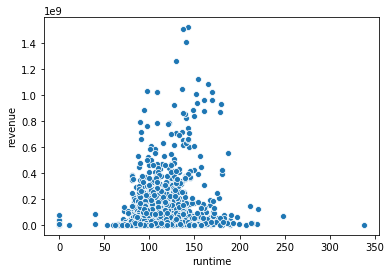

In [15]:
sns.scatterplot(x='runtime',y='revenue',data=train)

In [17]:
train['runtime'].mean(), train['runtime'].median(), train['runtime'].mode()

(107.85657104736491, 104.0, 0    90.0
 dtype: float64)

(array([ 12.,   1.,   0.,   0.,   0.,   2.,   0.,   1.,   1.,   5.,  18.,
         75., 186., 463., 567., 481., 280., 281., 202., 139.,  96.,  46.,
         39.,  39.,  15.,  14.,  12.,  10.,   3.,   2.,   1.,   3.,   2.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   6.76,  13.52,  20.28,  27.04,  33.8 ,  40.56,  47.32,
         54.08,  60.84,  67.6 ,  74.36,  81.12,  87.88,  94.64, 101.4 ,
        108.16, 114.92, 121.68, 128.44, 135.2 , 141.96, 148.72, 155.48,
        162.24, 169.  , 175.76, 182.52, 189.28, 196.04, 202.8 , 209.56,
        216.32, 223.08, 229.84, 236.6 , 243.36, 250.12, 256.88, 263.64,
        270.4 , 277.16, 283.92, 290.68, 297.44, 304.2 , 310.96, 317.72,
        324.48, 331.24, 338.  ]),
 <a list of 50 Patch objects>)

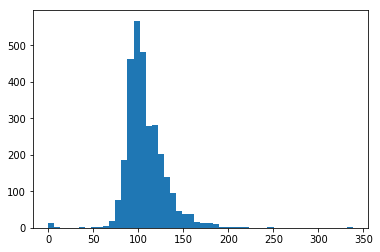

In [20]:
plt.hist(train['runtime'].values,bins=50)

In [29]:
train['runtime'] = train['runtime'].fillna(107)
train['run_dev'] = train['runtime'].map(lambda x: abs(x- 104))

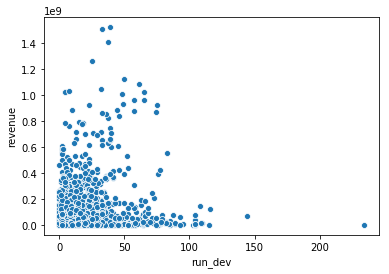

In [30]:
sns.scatterplot(x='run_dev',y='revenue',data=train)

In [31]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','runtime']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.001010313904628

In [32]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','run_dev']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.053724841931449

In [33]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','run_dev','runtime']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

3.986036543591183

### Test set

In [34]:
test['l_rev'] = test['original_language'].map(l_rev).fillna(13.61844005781211)

In [35]:
test['coll_id'] = test['belongs_to_collection'].fillna('[{"id":0}]').map(lambda x: (ast.literal_eval(x))[0]['id'])
test['coll_rev_logav'] = test['coll_id'].map(colls['log_of_averages']).fillna(0)

In [36]:
test['genres_id'] = test['genres'].fillna('[{"id":-1}]').map(lambda x: [i['id'] for i in (ast.literal_eval(x))])
test['genre_ave'] = test['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

In [37]:
test['production_ids'] = test['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [38]:
test['production_revs'] = test['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))

In [39]:
test['prod_ave'] = test['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
test['prod_top'] = test['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

In [40]:
# missing value - I filled with wikipedia info
test.loc[828,'release_date'] = '05/01/00'

In [41]:
test['year'] = test['release_date'].map(lambda x: (x.split('/'))[2])
test['year'] = test['year'].astype(int)
test['year'] = test['year'].map(lambda x: x+1900 if x>17 else x+2000)

In [43]:
test['runtime'] = test['runtime'].fillna(107)
test['run_dev'] = test['runtime'].map(lambda x: abs(x- 104))

In [44]:
submit = pd.read_csv('sample_submission.csv',index_col='id')
submit.head()

,revenue
id,
3001,1000000
3002,1000000
3003,1000000
3004,1000000
3005,1000000


In [45]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','runtime']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0503-rt.csv')

In [46]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','run_dev']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0503-rd.csv')

In [47]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','run_dev','runtime']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0503-run_both.csv')